# Assignment 17.10 - Challenge

To complete this challenge, submit a Jupyter notebook containing your solutions to the following tasks. Moreover, you can also submit a kernel to the Kaggle containing your solutions.

* Your goal in this challenge is to find the factors that affect the life expectancy. Specifically, you need to find out which factors increase the expected life in the countries and which factors decrease it.


* First, load the dataset.


* Detect the problems with the data such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable one in filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them. 


* Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy.



* In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.


* Summarize your findings. One of the most important skills of a data scientist is to convey ideas and findings to nontechnical people using understandable language. In this regard, one of the most effective ways to communicate your ideas is to do it using effective visualization.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as st
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import stats
from scipy.stats import t
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

### Loading Data

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

LIFE = pd.read_sql_query('select * from lifeexpectancy',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [3]:
LIFE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null

### There's white space in the column headers

Let's do away with that.

In [4]:
LIFE = LIFE.rename(columns=lambda x: x.strip())

### Proportion of missing values

In [5]:
for columns in LIFE:
    print(columns, LIFE[columns].isnull().sum()/len(LIFE[columns]))

Country 0.0
Year 0.0
Status 0.0
Life expectancy 0.0034036759700476512
Adult Mortality 0.0034036759700476512
infant deaths 0.0
Alcohol 0.06603131381892444
percentage expenditure 0.0
Hepatitis B 0.18822328114363512
Measles 0.0
BMI 0.011572498298162015
under-five deaths 0.0
Polio 0.006466984343090538
Total expenditure 0.07692307692307693
Diphtheria 0.006466984343090538
HIV/AIDS 0.0
GDP 0.1524846834581348
Population 0.22191967324710687
thinness  1-19 years 0.011572498298162015
thinness 5-9 years 0.011572498298162015
Income composition of resources 0.056841388699795777
Schooling 0.05547991831177672


#### Categorizing & Deciding How to Deal w/ Missing Data

Little's MCAR Test

    Tests the null hypothesis that the missing data is Missing Completely At Random (MCAR). A p.value of less than 0.05 is usually interpreted as being that the missing data is not MCAR (i.e., is either Missing At Random or non-ignorable).
    
        Unfortunately, I have been unable to run this test in Python so we will be looking at a visual representation of the missing data and carrying on from there. 


NaN Values can be;

    Missing Completely at Random (MCAR)
    Missing at Random (MAR)
    Missing Not at Random (MNAR)
    
    
If MAR and MCAR, then delete. Otherwise, impute.

### Visualizing Missing Data

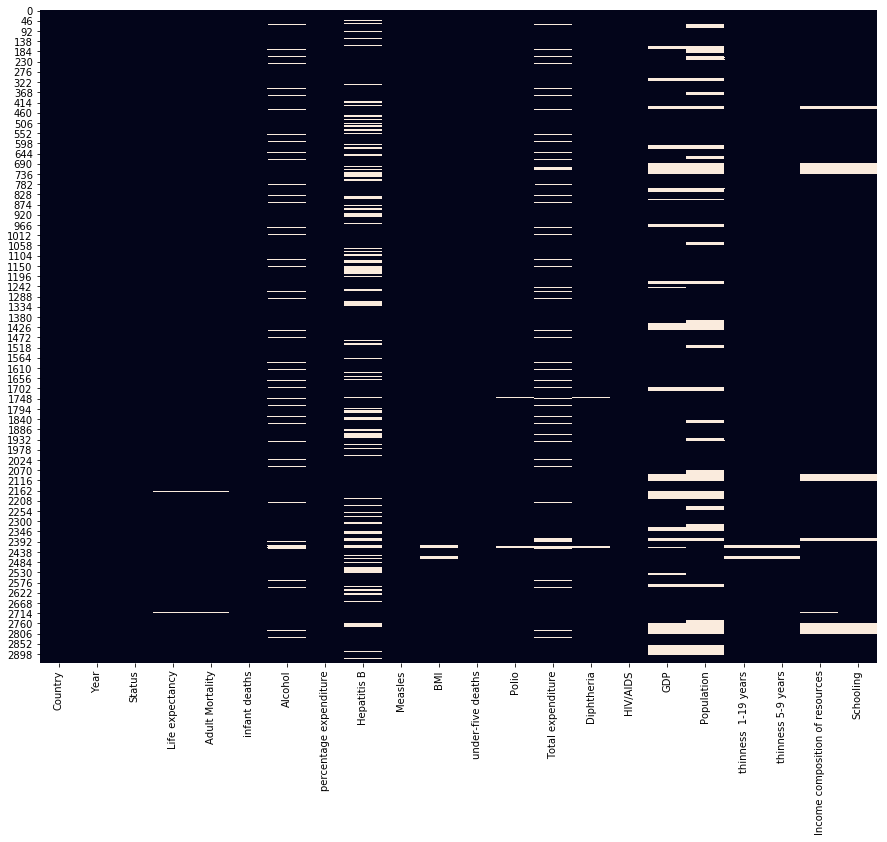

In [6]:
plt.figure(figsize=(15, 12))
sns.heatmap(LIFE.isnull(), cbar=False)

Based on the above heatmap, it appears that the data is not missing in a random fashion. With that in mind, I have decided to impute over the missing datapoints. As you will see some countries are missing entire vectors not just single observation values. 

### I assume that countries are fundamentally and culturally independent so I can fill Null values with the mean for that country. 


In [7]:
LIFE2 = LIFE.copy()

FILL_LIST = ['Life expectancy', 'Adult Mortality', 'infant deaths', 'Alcohol',
            'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 
            'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria', 
            'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years',
            'thinness 5-9 years', 'Income composition of resources', 
            'Schooling']

COUNTRIES = LIFE['Country'].unique()

for col in FILL_LIST:
    for country in COUNTRIES:
        LIFE2.loc[LIFE2["Country"] == country, col] = LIFE2.loc[LIFE2["Country"] == country, col].fillna(
            LIFE2[LIFE2["Country"] == country][col].mean())

### Oh No! there is still missing data!

#### There are countries that are missing values for entire vectors!

In [8]:
for columns in LIFE2:
    print(columns, LIFE2[columns].isnull().sum()/len(LIFE2[columns]))

Country 0.0
Year 0.0
Status 0.0
Life expectancy 0.0034036759700476512
Adult Mortality 0.0034036759700476512
infant deaths 0.0
Alcohol 0.005786249149081007
percentage expenditure 0.0
Hepatitis B 0.04901293396868618
Measles 0.0
BMI 0.011572498298162015
under-five deaths 0.0
Polio 0.0
Total expenditure 0.010891763104152484
Diphtheria 0.0
HIV/AIDS 0.0
GDP 0.1378488767869299
Population 0.2205582028590878
thinness  1-19 years 0.011572498298162015
thinness 5-9 years 0.011572498298162015
Income composition of resources 0.056841388699795777
Schooling 0.05547991831177672


In [9]:
LIFE_NA = LIFE2[LIFE2.isnull().any(axis=1)]
LIFE_NA.head(5)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
37,Côte d'Ivoire,2001,Developing,47.8,467.0,65,3.150000,0.000000,1.0,5790,...,7.0,4.850000,66.0,7.0,NaN,NaN,7.9,7.9,NaN,NaN
65,Antigua and Barbuda,2015,Developing,76.4,13.0,0,7.949333,0.000000,99.0,0,...,86.0,4.791333,99.0,0.2,13566.95410,NaN,3.3,3.3,0.784,13.9
66,Antigua and Barbuda,2014,Developing,76.2,131.0,0,8.560000,2422.999774,99.0,0,...,96.0,5.540000,99.0,0.2,12888.29667,NaN,3.3,3.3,0.782,13.9
67,Antigua and Barbuda,2013,Developing,76.1,133.0,0,8.580000,1991.430372,99.0,0,...,98.0,5.330000,99.0,0.2,12224.86416,NaN,3.3,3.3,0.781,13.9
68,Antigua and Barbuda,2012,Developing,75.9,134.0,0,8.180000,2156.229842,98.0,0,...,97.0,5.390000,98.0,0.2,12565.44197,NaN,3.3,3.3,0.778,13.8


### Proportion of countries missing entire categories

In [10]:
LIFE_NA.Country.nunique()/LIFE.Country.nunique()

0.31088082901554404

#### I think this may be too much data to throw away, but at the same time, I feel like a lot of analysis integrity might be lost by imputing over entire columns of null values relating to other countries. 

Best Guess Judgement: our task is not related to identifying countries in the data, it might be a good call to save some vector-specific data by imputing over other data-points. This trade-off means our data is more convenient, but we can not make an analysis based on the country. 

Mean Imputation

In [11]:
LIFE3 = LIFE.copy()

for col in FILL_LIST:
    LIFE3.loc[:, col] = LIFE3.loc[:, col].fillna(LIFE3.loc[:, col].mean())

Imputation by interpolation

In [12]:
LIFE4 = LIFE.copy()

for col in FILL_LIST:
    LIFE4.loc[:, col] = LIFE4.loc[:, col].fillna(LIFE4.loc[:, col].interpolate(limit_direction='both'))

In [13]:
for col in FILL_LIST[:1]:
    print("Statistics for columns: {}".format(col))
    print("original", "Mean", "Interpolation")
    print(pd.concat([LIFE[col], LIFE3[col],
                     LIFE4[col]], axis=1).describe())

Statistics for columns: Life expectancy
original Mean Interpolation
       Life expectancy  Life expectancy  Life expectancy
count      2928.000000      2938.000000      2938.000000
mean         69.224932        69.224932        69.214874
std           9.523867         9.507640         9.510819
min          36.300000        36.300000        36.300000
25%          63.100000        63.200000        63.100000
50%          72.100000        72.000000        72.000000
75%          75.700000        75.600000        75.600000
max          89.000000        89.000000        89.000000


### The Method using interpolation gave us a closer standard deviation to the original data set than the imputation method using the mean. 

Based on that I am going to say that the interpolated DataFrame is a better representation of the original DataFrame's central tendency in relation to variance. 


## Outlier Detection

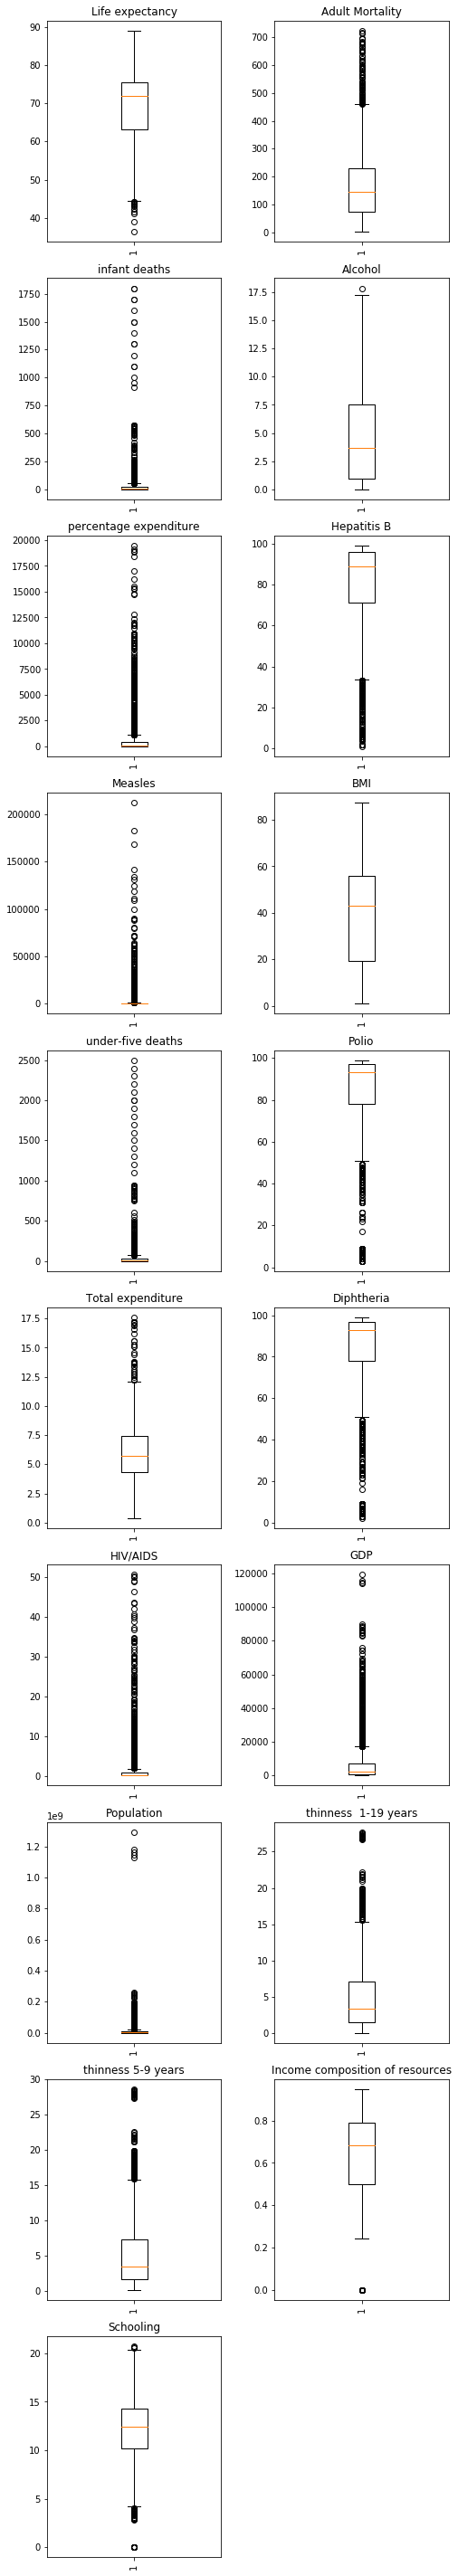

In [14]:
plt.figure(figsize=(7.5, 75))
plt.subplots_adjust(hspace=1, wspace=1)
for i, col in enumerate(FILL_LIST):
    plt.subplot(len(FILL_LIST), 2, i+1)
    plt.boxplot(x=col, data=LIFE4, whis=1.5)
    plt.xticks(rotation='vertical')
    plt.title(col)
    
plt.tight_layout()

### We have a lot of outliers here that skews the data away from a normal distribution. Some Machine Learning Models are sensitive to this, so in order to get an accurate response, we need to eliminate these values. 

To do this, I will winsorize these vectors using the 18.5% and 81.5% limits respectively

In [15]:
from scipy.stats.mstats import winsorize

WIN_LIFE4 = LIFE4.copy()

for col in FILL_LIST:
    WIN_LIFE4[col] = winsorize(WIN_LIFE4[col], (.185, .185))

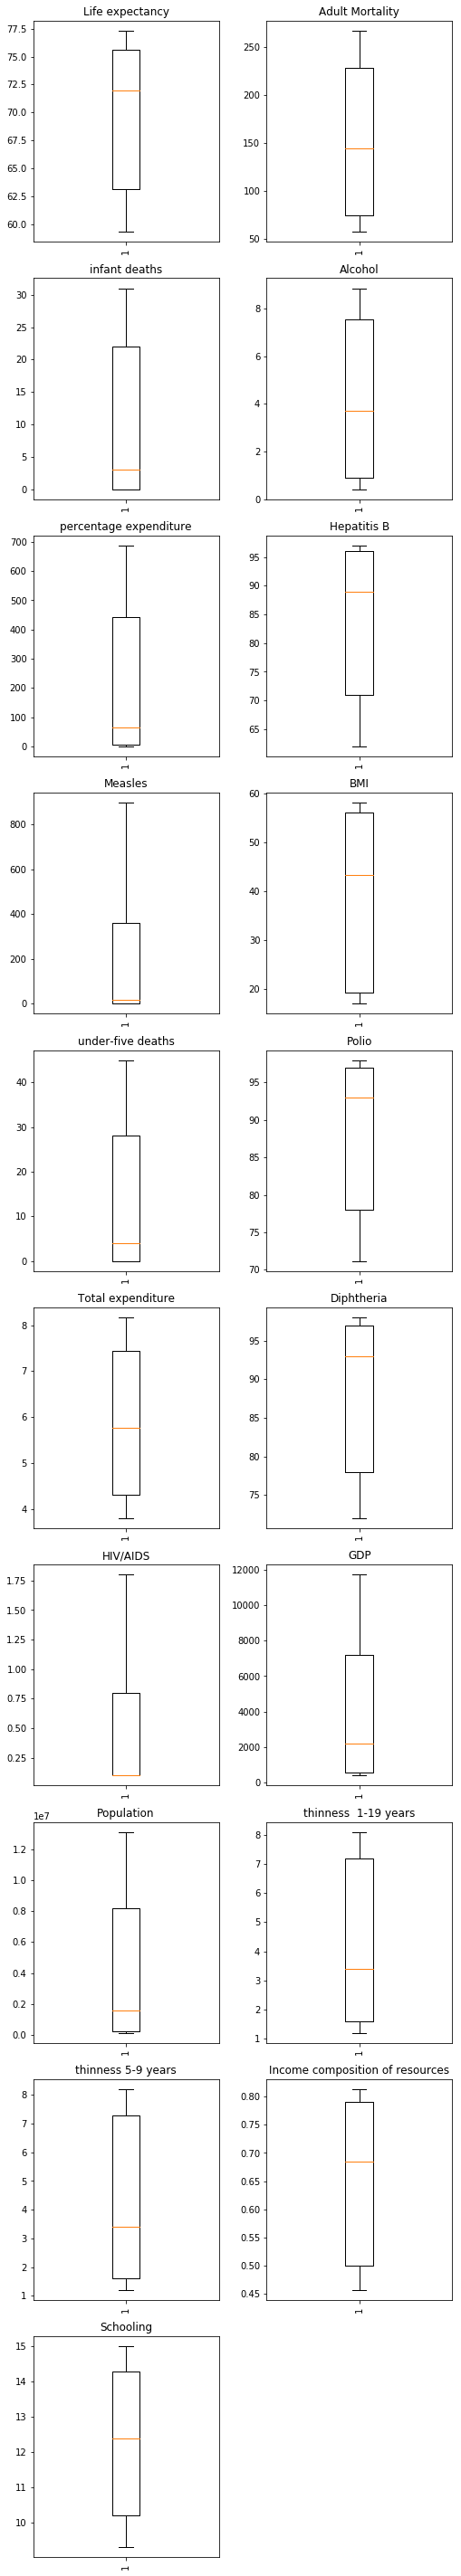

In [16]:
plt.figure(figsize=(7.5, 75))
plt.subplots_adjust(hspace=1, wspace=1)
for i, col in enumerate(FILL_LIST):
    plt.subplot(len(FILL_LIST), 2, i+1)
    plt.boxplot(x=col, data=WIN_LIFE4, whis=1.5)
    plt.xticks(rotation='vertical')
    plt.title(col)
    
plt.tight_layout()

That's better, now let's move on to exploring with our target in mind


## Univariate Analysis

### Status is our only categorical variable so let's take a look at that one first and its relationship with life expectancy then move on to the other continuous variables

In [17]:
WIN_LIFE4.Status.unique()

array(['Developing', 'Developed'], dtype=object)

In [18]:
WIN_LIFE4.groupby(WIN_LIFE4['Status'])['Life expectancy'].count()

Status
Developed      512
Developing    2426
Name: Life expectancy, dtype: int64

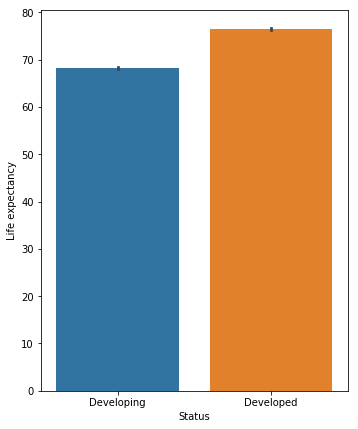

In [19]:
plt.figure(figsize=(5.5, 7))
sns.barplot(WIN_LIFE4['Status'], WIN_LIFE4['Life expectancy'])

#### It appears that life expectancy may not be independent of status, but the proportion of developing and developed countries may skew this. Also, remember we imputed over a lot of values that may also have some effect on what we're seeing. Additional studies specific to developing and developed countries should be done in a different way. 

In [20]:
WIN_LIFE4.groupby(WIN_LIFE4['Status'])['Life expectancy'].count()

Status
Developed      512
Developing    2426
Name: Life expectancy, dtype: int64

#### We can test for significance regarding the means of these two groups selecting a random sample from developing to not skew the result

In [21]:
from scipy.stats.mstats import ttest_ind

print(ttest_ind((WIN_LIFE4.loc[WIN_LIFE4.Status == 'Developed', 'Life expectancy']),
                (WIN_LIFE4.loc[WIN_LIFE4.Status == 'Developing', 'Life expectancy']).sample(n=512)))

Ttest_indResult(statistic=27.71731486060485, pvalue=1.481918476335469e-126)


#### It appears the differences observed between life expectancy depending on a country's status are significant.

### Continueous Variables

In [22]:
WIN_LIFE4.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,31,0.42,71.279624,65.0,896,...,71.166667,8.16,72.0,0.1,584.259210,13133589.0,8.1,8.2,0.479,10.1
1,Afghanistan,2014,Developing,59.9,267.0,31,0.42,73.523582,62.0,492,...,71.166667,8.17,72.0,0.1,612.696514,327582.0,8.1,8.2,0.476,10.0
2,Afghanistan,2013,Developing,59.9,267.0,31,0.42,73.219243,64.0,430,...,71.166667,8.13,72.0,0.1,631.744976,13133589.0,8.1,8.2,0.470,9.9
3,Afghanistan,2012,Developing,59.5,267.0,31,0.42,78.184215,67.0,896,...,71.166667,8.17,72.0,0.1,669.959000,3696958.0,8.1,8.2,0.463,9.8
4,Afghanistan,2011,Developing,59.3,267.0,31,0.42,7.097109,68.0,896,...,71.166667,7.87,72.0,0.1,387.753211,2978599.0,8.1,8.2,0.457,9.5


In [23]:
def sum_stats(df, col_names):
    sum_chart = ['Length', 'Mean', 'Median', 'Min', 'Max', 'STD',
                 'Variance', 'Kurtosis', 'Skew']
    stat_t = []
    for col in col_names:
        stat_t.append([len(df[col]), st.mean(df[col]), st.median(df[col]),
                       np.min(df[col]), np.max(df[col]),
                       np.std(df[col], ddof=23), np.var(df[col]),
                       kurtosis(df[col]), skew(df[col])])
    return pd.DataFrame(stat_t, index=col_names, columns=sum_chart)

### Summary Statistics

In [24]:
sum_stats(WIN_LIFE4, WIN_LIFE4.columns.values[3:])

,Length,Mean,Median,Min,Max,STD,Variance,Kurtosis,Skew
Life expectancy,2938,6.965466e+01,7.200000e+01,59.300000,7.730000e+01,6.747118e+00,4.516722e+01,-1.338439,-0.425961
Adult Mortality,2938,1.524566e+02,1.440000e+02,57.000000,2.670000e+02,7.859602e+01,6.128975e+03,-1.398856,0.235278
infant deaths,2938,1.008918e+01,3.000000e+00,0.000000,3.100000e+01,1.235180e+01,1.513726e+02,-1.009445,0.852834
Alcohol,2938,4.208174e+00,3.697500e+00,0.420000,8.860000e+00,3.257789e+00,1.053010e+01,-1.498451,0.250990
percentage expenditure,2938,2.208000e+02,6.491291e+01,0.000000,6.875117e+02,2.696526e+02,7.214331e+04,-0.919888,0.883167
Hepatitis B,2938,8.375214e+01,8.900000e+01,62.000000,9.700000e+01,1.361780e+01,1.839927e+02,-1.244095,-0.615591
Measles,2938,2.328914e+02,1.700000e+01,0.000000,8.960000e+02,3.533277e+02,1.238631e+05,-0.401455,1.181628
BMI,2938,3.877999e+01,4.325000e+01,17.000000,5.810000e+01,1.682996e+01,2.810303e+02,-1.693586,-0.152351
under-five deaths,2938,1.404459e+01,4.000000e+00,0.000000,4.500000e+01,1.779638e+01,3.142318e+02,-0.878635,0.927131
Polio,2938,8.793913e+01,9.300000e+01,71.166667,9.800000e+01,1.036574e+01,1.066075e+02,-1.207611,-0.648303


The mean gives us a measure of each vector's central tendency along with median, variance, and skew. Each vector has a low kurtosis and as we'll see with the following plots, it appears most of each vector's data points are located in the tails of the recorded data. 

### Density Plots

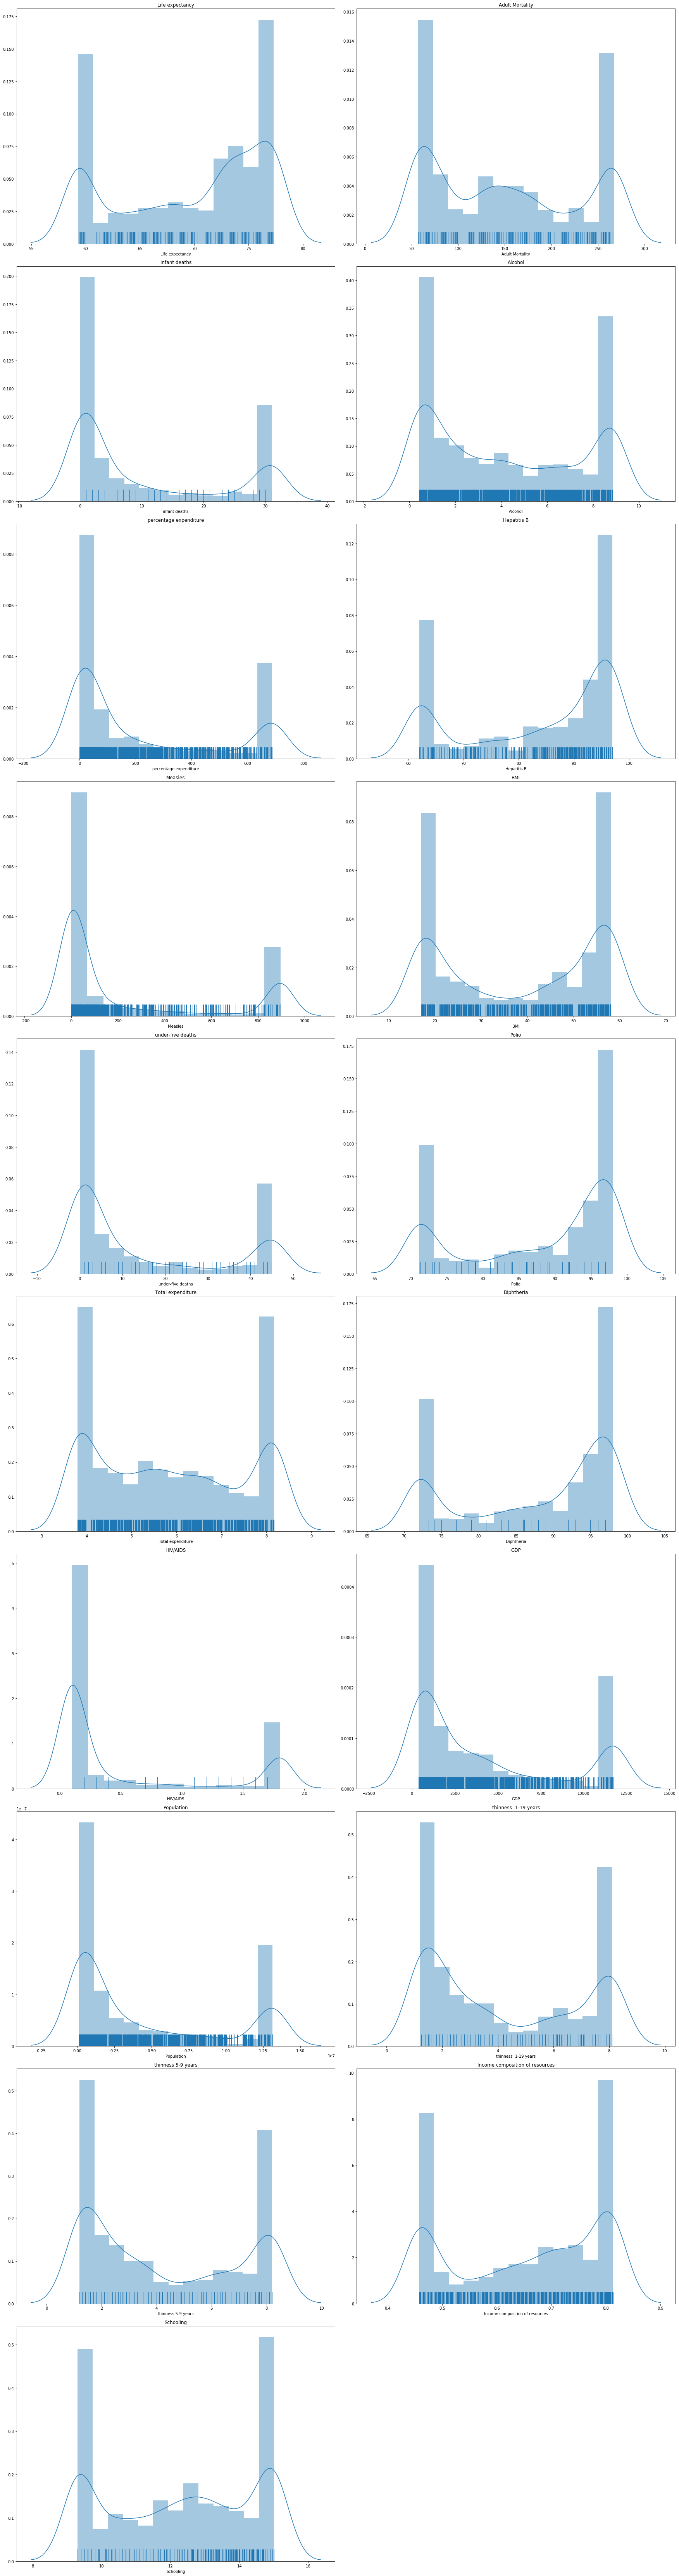

In [25]:
plt.figure(figsize=(24.5, 175))
plt.subplots_adjust(hspace=1, wspace=1)
for i, col in enumerate(FILL_LIST):
    plt.subplot(len(FILL_LIST), 2, i+1)
    sns.distplot(WIN_LIFE4[col], rug=True, bins=13)
    plt.title(col)
    
plt.tight_layout()

# Bivariate Analysis


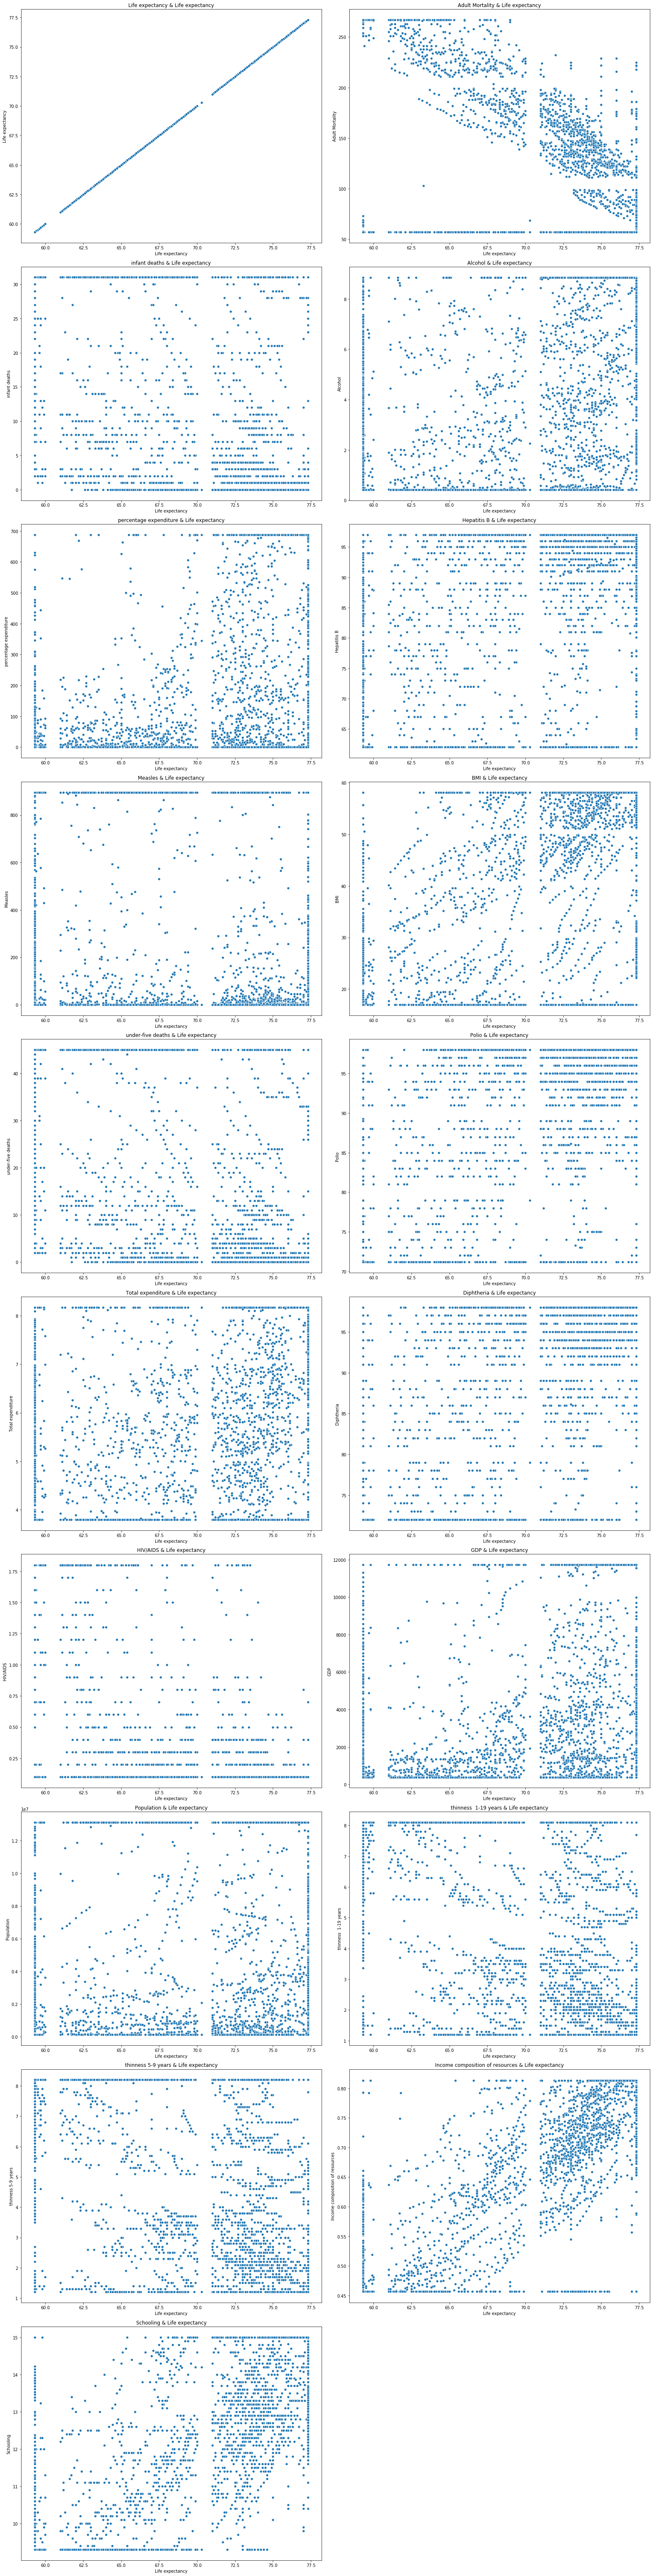

In [26]:
plt.figure(figsize=(22.05, 164))
plt.subplots_adjust(hspace=1, wspace=1)
for i, col in enumerate(FILL_LIST):
    plt.subplot(len(FILL_LIST), 2, i+1)
    sns.scatterplot(x='Life expectancy', y=col, data=WIN_LIFE4)
    plt.title(col+' & Life expectancy')
    
plt.tight_layout()

Some of the above scatter plots are hinting to us that some of the features in our dataset have some kind of relationship with the life expectancy vector that we are interested in. 

Moving on let's look at a couple of bivariate densities plots to elaborate on what is shown above. 

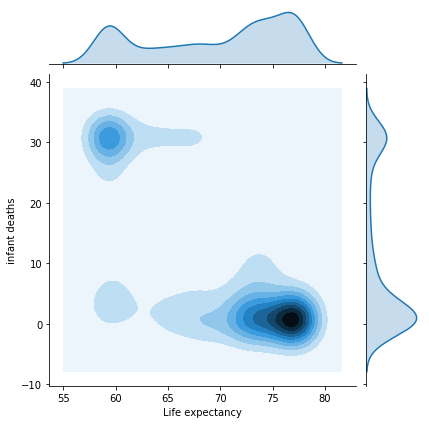

In [27]:
sns.jointplot(x='Life expectancy', y='infant deaths', data=WIN_LIFE4, kind='kde')

The above plot displays an expected relationship between variables. Low infant mortality would obviously negatively impact life expectancy reports for a region. 

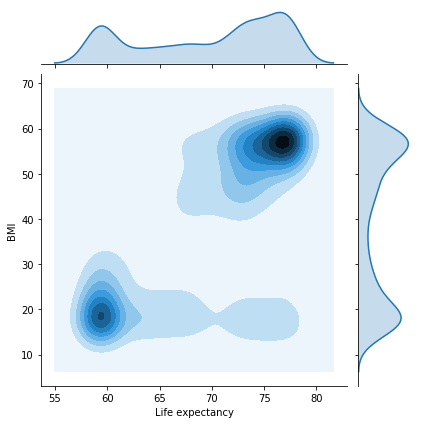

In [28]:
sns.jointplot(x='Life expectancy', y='BMI', data=WIN_LIFE4, kind='kde')

The above relationship is interesting and telling because the highest density of observations with a life expectancy between 75 and 80 years also has a higher BMI index than the life expectancy observations with 55 to 65 years. 

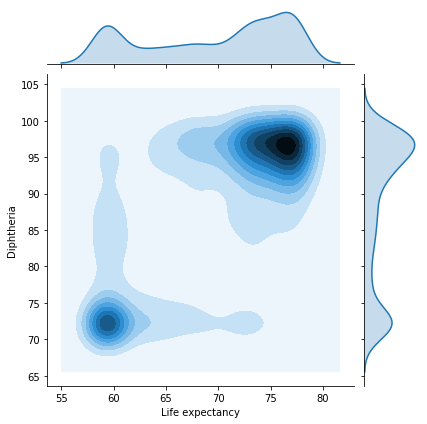

In [29]:
sns.jointplot(x='Life expectancy', y='Diphtheria', data=WIN_LIFE4, kind='kde')

Diphtheria - A serious infection of the nose and throat that's easily preventable by a vaccine.

What makes the above plot interesting is that high life expectancy and diphtheria go hand and hand. Diphtheria can cause death, which seems counter-intuitive to this plot. 

This leads me to believe the difference in reports has a lot to do with the availability of vaccines.

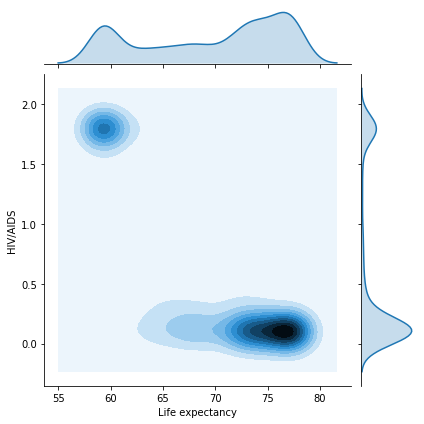

In [30]:
sns.jointplot(x='Life expectancy', y='HIV/AIDS', data=WIN_LIFE4, kind='kde')

To the contrary of the relationship shown regarding Diphtheria, high infection of HIV/AIDS adversely affects life expectancy. 

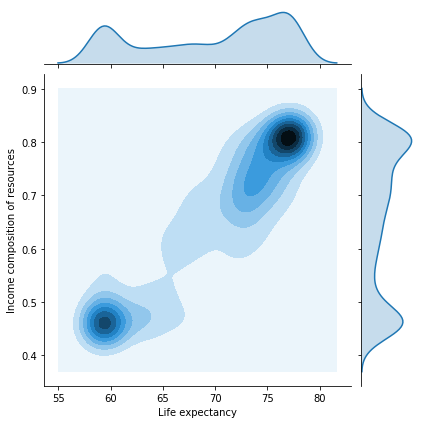

In [31]:
sns.jointplot(x='Life expectancy', y='Income composition of resources', data=WIN_LIFE4, kind='kde')

This plot displays a dense positive relationship between income resources and life expectancy. 

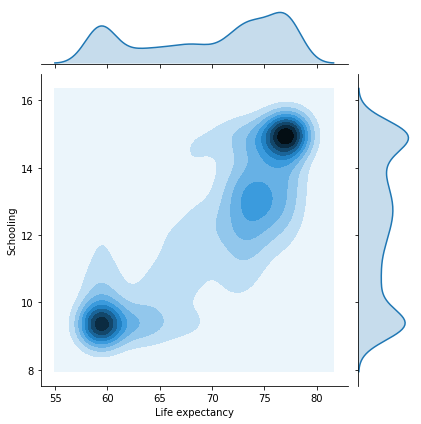

In [32]:
sns.jointplot(x='Life expectancy', y='Schooling', data=WIN_LIFE4, kind='kde')

Much like the income plot, schooling shows a similar relationship between its indexed value and life expectancy. 

### Qualitative Correlation Analysis of Continueuos Variables

In [33]:
WIN_LIFE4.corr()[1:2].T

,Life expectancy
Year,0.119197
Life expectancy,1.000000
Adult Mortality,-0.683953
infant deaths,-0.590083
Alcohol,0.416893
percentage expenditure,0.490975
Hepatitis B,0.377643
Measles,-0.349419
BMI,0.638129
under-five deaths,-0.615494


Text(0.5, 1.0, 'Pearson Correlation Heatmap')

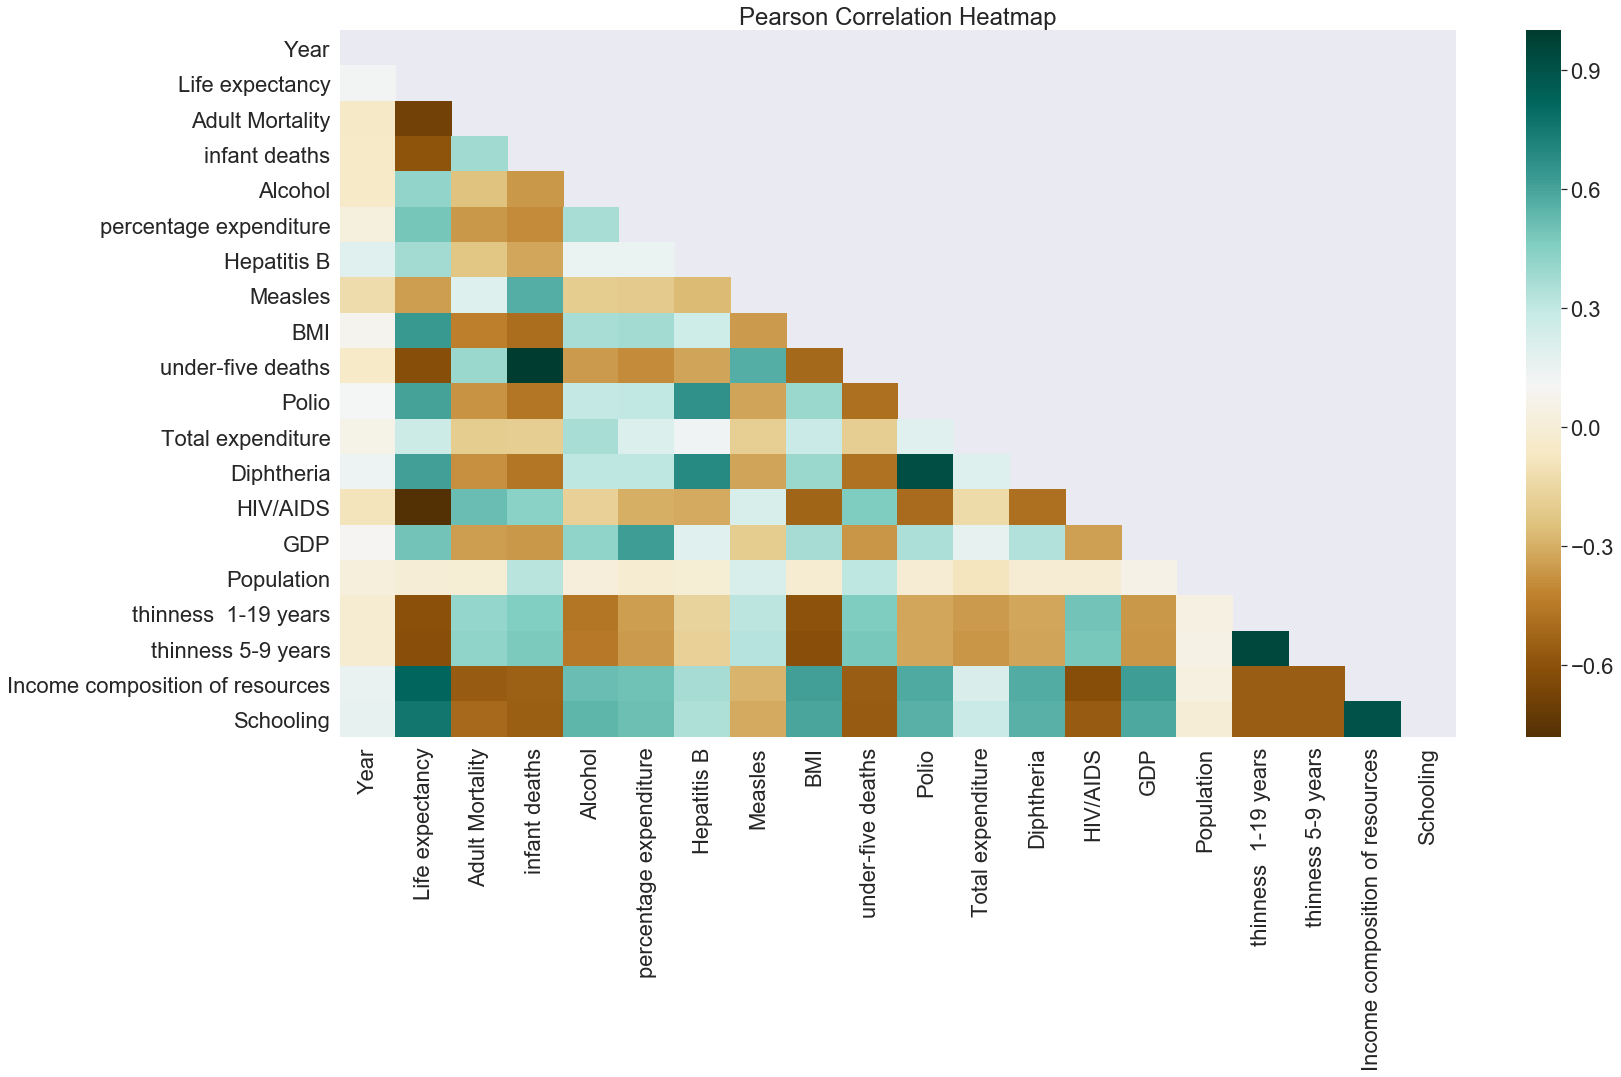

In [34]:
plt.figure(figsize=(25, 13))
sns.set(font_scale=2)
mask = np.zeros_like(WIN_LIFE4.corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("darkgrid"):
    ax = sns.heatmap(WIN_LIFE4.corr(), cmap="BrBG", mask=mask)
plt.title('Pearson Correlation Heatmap')

In [35]:
WIN_LIFE4.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,31,0.42,71.279624,65.0,896,...,71.166667,8.16,72.0,0.1,584.259210,13133589.0,8.1,8.2,0.479,10.1
1,Afghanistan,2014,Developing,59.9,267.0,31,0.42,73.523582,62.0,492,...,71.166667,8.17,72.0,0.1,612.696514,327582.0,8.1,8.2,0.476,10.0
2,Afghanistan,2013,Developing,59.9,267.0,31,0.42,73.219243,64.0,430,...,71.166667,8.13,72.0,0.1,631.744976,13133589.0,8.1,8.2,0.470,9.9
3,Afghanistan,2012,Developing,59.5,267.0,31,0.42,78.184215,67.0,896,...,71.166667,8.17,72.0,0.1,669.959000,3696958.0,8.1,8.2,0.463,9.8
4,Afghanistan,2011,Developing,59.3,267.0,31,0.42,7.097109,68.0,896,...,71.166667,7.87,72.0,0.1,387.753211,2978599.0,8.1,8.2,0.457,9.5


At this stage, we can see that the Pearson correlations range from approximately -.9 to .8. Some variables are more useful than others. 

In [36]:
WIN_CORR = WIN_LIFE4.corr()

In [37]:
WIN_CORR.sort_values(by=['Life expectancy', 'Income composition of resources', 'Schooling',
                        'BMI', 'Diphtheria', 'Polio', 'infant deaths', 
                        'thinness 5-9 years', 'under-five deaths', 'Adult Mortality',
                        'HIV/AIDS'], ascending=False)

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
Life expectancy,0.119197,1.000000,-0.683953,-0.590083,0.416893,0.490975,0.377643,-0.349419,0.638129,-0.615494,0.610339,0.266707,0.613121,-0.780985,0.493311,0.001202,-0.602567,-0.607717,0.824642,0.761704
Income composition of resources,0.154811,0.824642,-0.562495,-0.538886,0.518296,0.502768,0.373723,-0.284482,0.616048,-0.557814,0.582276,0.214478,0.573479,-0.614876,0.622077,0.034188,-0.557563,-0.555840,1.000000,0.901664
Schooling,0.159977,0.761704,-0.503310,-0.548030,0.542400,0.506076,0.352036,-0.314504,0.593602,-0.561313,0.557681,0.278773,0.554780,-0.561352,0.588225,0.004123,-0.555414,-0.554798,0.901664,1.000000
BMI,0.083424,0.638129,-0.429302,-0.494331,0.361548,0.374595,0.258252,-0.352330,1.000000,-0.514318,0.398438,0.282801,0.399446,-0.526319,0.370975,-0.018204,-0.598919,-0.611958,0.616048,0.593602
Diphtheria,0.139548,0.613121,-0.380421,-0.461862,0.307489,0.309984,0.693473,-0.324451,0.399446,-0.479009,0.918526,0.194111,1.000000,-0.487248,0.343094,-0.013922,-0.321024,-0.326845,0.573479,0.554780
Polio,0.111938,0.610339,-0.373799,-0.466181,0.294766,0.299904,0.663184,-0.324512,0.398438,-0.482910,1.000000,0.186939,0.918526,-0.496696,0.354494,-0.015051,-0.314915,-0.321366,0.582276,0.557681
GDP,0.102216,0.493311,-0.347112,-0.361768,0.428947,0.619457,0.190446,-0.199433,0.370975,-0.365077,0.354494,0.165988,0.343094,-0.341443,1.000000,0.055473,-0.357901,-0.364327,0.622077,0.588225
percentage expenditure,0.032031,0.490975,-0.363250,-0.396142,0.364308,1.000000,0.149033,-0.208311,0.374595,-0.395567,0.299904,0.208446,0.309984,-0.297424,0.619457,-0.021474,-0.346683,-0.351519,0.502768,0.506076
Alcohol,-0.048927,0.416893,-0.243866,-0.358026,1.000000,0.364308,0.146049,-0.201303,0.361548,-0.354620,0.294766,0.360618,0.307489,-0.176417,0.428947,0.015523,-0.464148,-0.452092,0.518296,0.542400
Hepatitis B,0.191807,0.377643,-0.230541,-0.318111,0.146049,0.149033,1.000000,-0.262848,0.258252,-0.328113,0.663184,0.132077,0.693473,-0.312456,0.190446,-0.004240,-0.162308,-0.177031,0.373723,0.352036


### The features I would want to keep include:
1. Life expectancy
1. Income composition of resources (dropping BMI, schooling, and HIV/AIDS because of its correlation to this vector)
1. Diphtheria (dropping Polio because of its correlation to this vector)
1. thinness 5-9 years (dropping thinness 1-19 years because of its correlation to this vector)
1. under-five deaths (dropping infant deaths and Polio because of its correlation to this vector)
1. Adult Mortality

### Why?

The reason I choose to keep these vectors and drop others is based on correlations. Vectors that were strongly correlated with our target were kept, then considering the inter-correlations I dropped vectors that were heavily correlated with each other and kept the variable that was more correlated with our target. 

Vectors with more than .6 or less than -.6 correlation were kept unless they were more correlated with other variables, then the most correlated vector was kept and the others were dropped. 

Everything between .5 to -.5 does not tell us enough about our target to be kept for modeling. 


## In Summary

The features were chosen to tell us the most about life expectancy with the least amount of redundancy included in the dataset. The reason we want to do this is to maximize what we can get out of a model while also minimizing the computational power or (computerized workload) needed to make a prediction. 